# CLV Calculation in Non-Contractual Business

This notebook is the first step in a deeper analysis of the [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) package.
The pre-cleaned data is transformed and CLV for the different customers is calculated.

#### Data Source
- `data/interim/clv_data.csv`: Cleaned data, prepared in first notebook.

#### Data Output
- `data/processed/clv_data_output.csv`: Processed data with CLVs added. Will be used for analysis / validation in nb 3.

#### Changes
- 19-02-12: Start notebook
- 19-02-15: Calculate CLVs, Finish notebook

---

### Import libraries, load data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
from lifetimes import BetaGeoFitter

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(), sns.set_style('whitegrid')
%matplotlib inline  

# special settings for lifetime plots
sns.set_palette("viridis")
sns.set(rc={'image.cmap': 'viridis'})

import cleaning_functions as clean
import EDA_functions as EDA

# display of all columns in df
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
# Load data
clv_data = pd.read_csv('data/interim/clv_data.csv', parse_dates=['InvoiceDate'],
                       dtype={'CustomerID' : str, 'Country' : 'category'})

## 1) Prepare Data


In [3]:
clv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 6 columns):
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null object
Country        397884 non-null category
Sales          397884 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 15.6+ MB


**Note:** For Lifetimes we need an Input Dataframe of transaction data of the form: 
- customer_id
- datetime 
- [monetary_value] (optional, but needed for clv estimations)

### Clean & Transform Data

In [4]:
"""Transform data to 'Lifetimes' format"""

clv_data.drop(['Quantity', 'UnitPrice', 'Country'], inplace=True, axis=1)
clv_data['InvoiceDate'] = clv_data['InvoiceDate'].dt.date

# Use transformation function from liftimes package
clv = summary_data_from_transaction_data(clv_data, 
                                         customer_id_col='CustomerID', 
                                         datetime_col='InvoiceDate', 
                                         monetary_value_col='Sales')

In [5]:
# Check results
print(clv.shape)
clv.head()

(4338, 4)


,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


**Nomenclature for the CLV model:**

- _Frequency_: represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. (Thus if they have made only 1 purchase, the recency is 0.)
- _T_: represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- _Recency_: represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

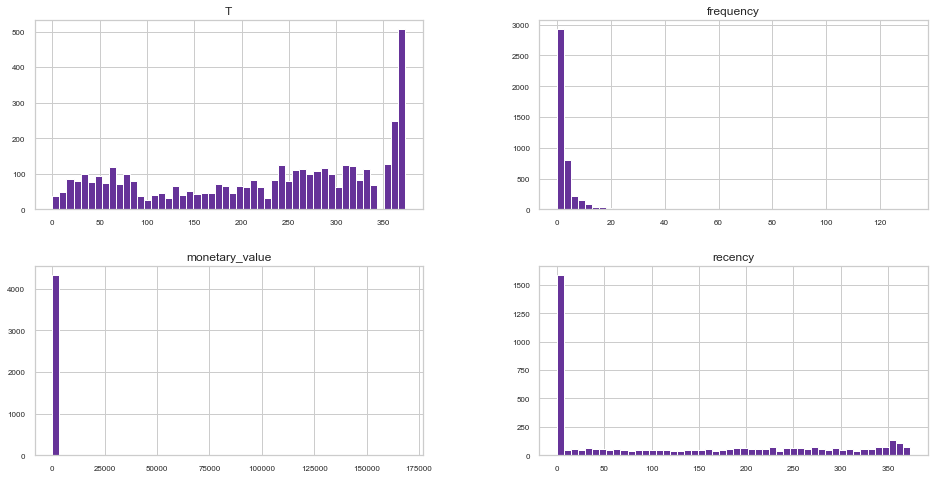

In [6]:
# Check distributions - should be the same as in the EDA notebook (apart from monetary value)
EDA.plot_num_hist(clv, figsize=(16,8))

In [7]:
print("prop of customers without repeat purchase: ", round(clv['frequency'].value_counts()[0]/len(clv),3))

prop of customers without repeat purchase:  0.357


## 2) Forecast number of future purchases with BG / NBD model
The BG /NBD model allows us to compute the expected number of purchases in a forecast period at the customer level.

In [11]:
# Fit model with calibration and holdout sets
summary_cal_holdout = calibration_and_holdout_data(clv_data, 'CustomerID', 'InvoiceDate', 
                                                   monetary_value_col='Sales',
                                                   calibration_period_end='2011-06-09',  # 9 months
                                                   observation_period_end='2011-12-09',  # 4 months
                                                   ) 

In [70]:
# Check results
print(summary_cal_holdout.shape)
display(summary_cal_holdout.head())

(2800, 7)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,142.0,0.000000,0.0,0.000000,183
12347,3.0,184.0,184.0,498.053333,3.0,26.300625,183
12348,2.0,110.0,175.0,297.220000,1.0,103.333333,183
12350,0.0,0.0,127.0,0.000000,0.0,0.000000,183
12352,3.0,34.0,113.0,421.770000,3.0,20.090000,183


**Note:** Only 2800 customers are in the fitting set, because the others made their first order only in the holdout period. (I checked that with the original 'customers_data'.)

In [13]:
# 'Repair' duration_holdout: set to float - should not happen according to docs ...
import re
summary_cal_holdout['duration_holdout'] = \
    summary_cal_holdout['duration_holdout'].astype(str)    
summary_cal_holdout['duration_holdout'] = \
    summary_cal_holdout['duration_holdout'].apply(lambda x: int(re.findall('\d+', x)[0]))

In [14]:
# Check results
display(summary_cal_holdout.head())

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,142.0,0.000000,0.0,0.000000,183
12347,3.0,184.0,184.0,498.053333,3.0,26.300625,183
12348,2.0,110.0,175.0,297.220000,1.0,103.333333,183
12350,0.0,0.0,127.0,0.000000,0.0,0.000000,183
12352,3.0,34.0,113.0,421.770000,3.0,20.090000,183


In [15]:
# fit on the _cal columns, and test on the _holdout columns"""

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2800 subjects, a: 0.00, alpha: 61.16, b: 6.79, r: 0.74>

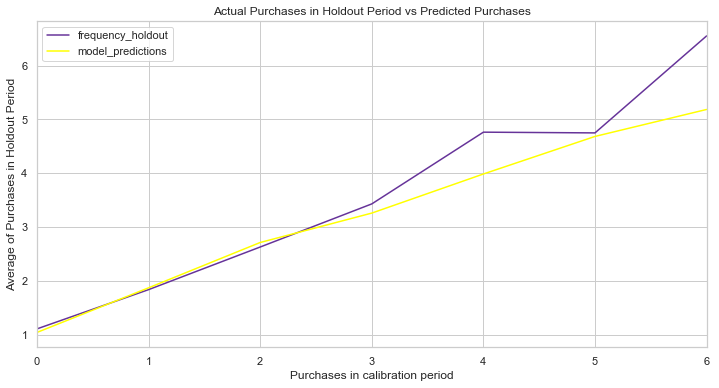

In [16]:
# plot results
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, figsize=(12,6),
                                                color=['rebeccapurple', 'yellow']);

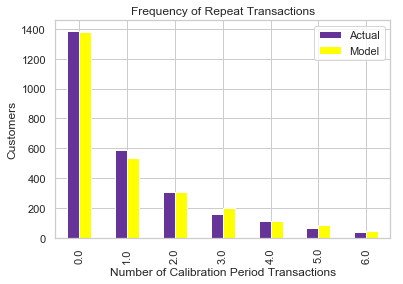

In [17]:
# Assess model fit (with simulated data, cal_period only)
plot_period_transactions(bgf, color=['rebeccapurple', 'yellow']);

### Calculate and Evaluate Individual Customer Predictions
Based on customer history, we can predict how many future purchases an individual might make in a given period.

In [66]:
def predict_individual_purchases(model, df, t):
    """Predict number of purchases for period t for each customer
    and return them, rounded to int, in a DataFrame.
    """
    pred_list = []
    for customer in df.itertuples():
        pred_purchases = model.predict(t, 
                                     int(customer[1]), 
                                     int(customer[2]), 
                                     int(customer[3])
                                     )
        pred_list.append({'id': customer[0], 
                          'pred_purchases': int(pred_purchases)})  # round to int

    pred_df = pd.DataFrame(pred_list, columns=['id', 'pred_purchases'])
    pred_df.set_index('id', inplace=True)
    
    return pred_df

In [67]:
# Call function and check results
t = summary_cal_holdout.iloc[0,-1]  # set no of periods == duration_holdout
pred_purchases = predict_individual_purchases(bgf, clv, t)
display(pred_purchases.head())

,pred_purchases
id,
12346,0
12347,2
12348,1
12349,1
12350,0


In [79]:
# Compare predictions to effective frequencies in holdout set
pred_evaluation = pd.concat([pred_purchases, 
                             summary_cal_holdout[['frequency_holdout']]], 
                            axis=1, 
                            sort=True
                            )

# For eval only look a customers with frequency value in holdout
pred_evaluation.dropna(how = 'any', inplace=True)
assert len(pred_evaluation) == len(summary_cal_holdout)

print("Pearson's R: ", round(pred_evaluation.corr().iloc[0,1],3))

Pearson's R:  0.97


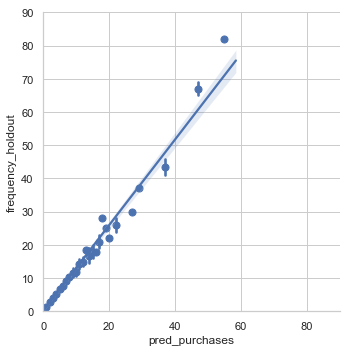

In [88]:
sns.lmplot(x="pred_purchases", 
           y="frequency_holdout", 
           data=pred_evaluation, 
           x_estimator=np.mean,
           palette=['rebeccapurple', 'yellow']);

plt.xlim(0, 90)
plt.ylim(0, 90);

**Observation:** The correlation is very high, but the (linear) prediction constantly underestimates the effective purchases.

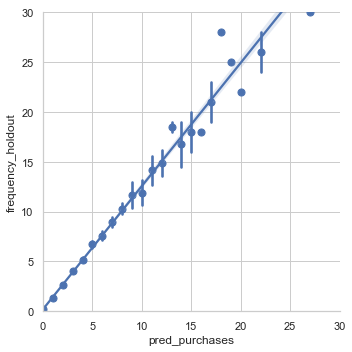

In [93]:
# Trim outliers
pred_evaluation_trimmed = pred_evaluation.loc[
        pred_evaluation['frequency_holdout'] <= 30]

sns.lmplot(x="pred_purchases", 
           y="frequency_holdout", 
           data=pred_evaluation_trimmed, 
           x_estimator=np.mean,
           palette=['rebeccapurple', 'yellow']);

plt.xlim(0, 30)
plt.ylim(0, 30);

**Observation:*** The fit is a little better but the prediction is still to low.

## 3) Estimate customer lifetime value using the Gamma-Gamma model
To estimate the CLV we use the [Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). It can be seen as an extension to the BG/NBD, whichfocuses on modeling purchase count. Gamma-Gamma makes a few assumptions:
* At the customer level, the transaction/order value varies randomly around each customer’s average transaction value. (That, in itself, isn’t too controversial, but has to be checked, see below.)
* The observed mean value is an imperfect metric of the latent mean transaction value E(M), where M represents the monetary value.
* Average transaction value varies across customers, though these values are stationary. (This is a big assumption to make.)
* The distribution of average values across customers is independent of the transaction process. In other words, monetary value can be modeled separately from the purchase count and lifetime components of the model. This may or may not hold in typical business situations.

**IMPORTANT:** Fit only to returning customers (but you can predict for all)

In [95]:
# Drop all one-time-only customers as clv can only be calculated for returning customers

returning_customers = clv[clv['frequency'] > 0]
print(len(returning_customers))
display(returning_customers.head())

2790


,frequency,recency,T,monetary_value
CustomerID,,,,
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12352,6.0,260.0,296.0,368.256667
12356,2.0,303.0,325.0,269.905000
12358,1.0,149.0,150.0,683.200000


In [96]:
# Check for independence between Frequency and Monetary Value
print("Pearson's r: ", round(np.corrcoef(returning_customers['monetary_value'],
                                         returning_customers['frequency'])[0][1], 2))

Pearson's r:  0.02


In [97]:
# Fit Gamma-Gamma-Model on returning customers
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

# Check results
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>


In [100]:
# Predict CLV for a given period (in months) with bgf and ggf

clv_estimates = ggf.customer_lifetime_value(
    bgf,
    clv['frequency'],
    clv['recency'],
    clv['T'],
    clv['monetary_value'],
    time=4, # in months
    discount_rate=0.00)  # none for evaluation purposes

In [101]:
# Check results
display(clv_estimates.head())

CustomerID
12346      96.096046
12347    1076.965032
12348     357.546906
12349     468.778426
12350      99.979657
Name: clv, dtype: float64

### Estimate average transaction values

This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

In [104]:
avg_value = ggf.conditional_expected_average_profit(clv['frequency'],
                                                    clv['monetary_value'])

# check resutls
avg_value.head()

CustomerID
12346    416.945976
12347    569.978822
12348    333.784225
12349    416.945976
12350    416.945976
dtype: float64

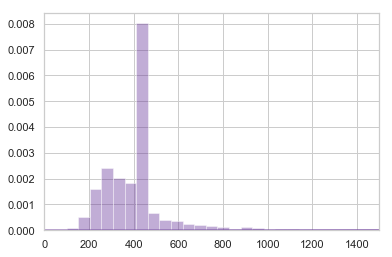

In [121]:
sns.distplot(avg_value, bins=1500, color='rebeccapurple')
plt.xlim(0,1500);

**Observation:** The distribution differs quite a bit from the original values.

In [117]:
# Compare mean of all avg_predictions vs effectively observed values
print("Expected conditional average value:", avg_value.mean()) # all customers
print("Observed average value:", returning_customers['monetary_value'].mean()) # returning only!

Expected conditional average value: 441.15941642512496
Observed average value: 477.3803385139518


**Note:** You cannot directly compare to monetary_value in clv_data, because the value of the first purchase is not calculated. From EDA I know that the average value per customer is 458 - pretty close.

---